In [12]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload

# always import gbm_algos first !
import xgboost, lightgbm, catboost

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io
from torch.autograd import grad
import shap
from utils import *
from models import *

from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from mlens.ensemble import SuperLearner, BlendEnsemble

from collections import OrderedDict
from tqdm import tqdm, trange

from lbfgsnew import LBFGSNew
from madgrad import MADGRAD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_PATH = "/Users/pongpisit/Desktop/research/pinn/Solving-Differential-Equations-with-Neural-Networks/SymbolicMathematics/data/burgers_shock.mat"
data = io.loadmat(DATA_PATH)

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

N = 2000
print(f"Training with {N} samples")
idx = np.random.choice(X_star.shape[0], N, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx,:]

# Convert to torch.tensor
X_u_train = torch.tensor(X_u_train).float().requires_grad_(True)
u_train = torch.tensor(u_train).float().requires_grad_(True)
X_star = torch.tensor(X_star).float().requires_grad_(True)
u_star = torch.tensor(u_star).float().requires_grad_(True)

feature_names=['uf', 'u_x',  'u_xx', 'u_tt', 'u_xt', 'u_tx']

Training with 2000 samples


### Using statistical models to find feature importance.

In [3]:
### Old implementation, loading derivatives and dynamics ###
# version = "V1.npy"
# print("Using version:", version)

# # It is better to scale the derivative features before fitting models in terms of the accuracy
# # Use numpy_minmax_normalize from utils.py
# X_np = np.load("./saved_path_inverse_burger/lbfgsnew_results/data/derivatives-2000-"+version)
# y_np = np.load("./saved_path_inverse_burger/lbfgsnew_results/data/dynamics-2000-"+version).ravel()
# X_np_test = np.load("./saved_path_inverse_burger/lbfgsnew_results/data/derivatives-25600-"+version)
# y_np_test = np.load("./saved_path_inverse_burger/lbfgsnew_results/data/dynamics-25600-"+version).ravel()

### New implementation, computing derivatives and dynamics from semisup_model ###
semisup_model_state_dict = torch.load("./saved_path_inverse_burger/lbfgsnew_results/semisup_model_with_LayerNormDropout_without_physical_reg_trained250labeledsamples_trained125unlabeledsamples_4.1e-04.pth")
semisup_model = SemiSupModel(network=Network(model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1], activation_function=nn.Tanh(), bn=nn.LayerNorm, dropout=None)),
                             selector=SeclectorNetwork(X_train_dim=6, bn=nn.LayerNorm),
                             normalize_derivative_features=True, 
                             mini=None, 
                             maxi=None)
semisup_model.load_state_dict(semisup_model_state_dict)

# Used for training the selector network
derivatives, dynamics = semisup_model.network.get_selector_data(*dimension_slicing(X_u_train))
X_np, y_np = to_numpy(derivatives), to_numpy(dynamics).ravel()

# Used for training the GBM algos
derivatives, dynamics = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
X_np_full, y_np_full = to_numpy(derivatives), to_numpy(dynamics).ravel()

In [4]:
meta = Ridge()
xg = xgboost.XGBRegressor(reg_alpha=0.1)
cat = catboost.CatBoostRegressor(iterations=None, depth=4, learning_rate=0.1, verbose=0, l2_leaf_reg=10)
light = lightgbm.LGBMRegressor(n_estimators=200, learning_rate=0.1, reg_lambda=1)

In [7]:
ensemble = SuperLearner(scorer=mean_squared_error, model_selection=True, n_jobs=3)
ensemble.add([xg, light, cat])
ensemble.add_meta(meta)
ensemble.fit(X_np_full, y_np_full)

SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...774cca0>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=True, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20,
       scorer=<function mean_squared_error at 0x13774cca0>, shuffle=False,
       verbose=False)

In [8]:
print("Ensemble model")
sklearn_model = SklearnModel(model=ensemble, X_train=X_np_full, y_train=y_np_full, feature_names=feature_names)
print('Training GBM algos...')
print()

print("Xgboost")
xg = SklearnModel(model=xg, X_train=X_np_full, y_train=y_np_full, feature_names=feature_names)
xg_feature_importance = xg.feature_importance()
print()

print("LightGBM")
light = SklearnModel(model=light, X_train=X_np_full, y_train=y_np_full, feature_names=feature_names)
light_feature_importance = light.feature_importance()
print()

print("Catboost")
# Showing the best performance
cat = SklearnModel(model=cat, X_train=X_np_full, y_train=y_np_full, feature_names=feature_names)
cat_feature_importance = cat.feature_importance()
print()

Ensemble model
Done training
Training MSE: 0.29668742
Training GBM algos...

Xgboost
Done training
Training MSE: 0.00052377617
('u_xx', 0.32160449746857206)
('u_tt', 0.22026320294134027)
('u_x', 0.1786465982790276)
('u_xt', 0.16042589009760075)
('uf', 0.11905981121345932)
('u_tx', 0.0)

LightGBM
Done training
Training MSE: 0.002392654525266061
('uf', 0.265)
('u_x', 0.20483333333333334)
('u_xx', 0.1955)
('u_tt', 0.18866666666666668)
('u_xt', 0.14583333333333334)
('u_tx', 0.00016666666666666666)

Catboost
Done training
Training MSE: 0.0021810399738819175
('u_x', 0.42507481593238866)
('uf', 0.2616790888300163)
('u_xx', 0.1536739643113169)
('u_tt', 0.08800727848666001)
('u_xt', 0.04045946252046118)
('u_tx', 0.031105389919156914)



In [9]:
avg_feature_importances = {}
for f in feature_names:
    avg_feature_importances[f] = (xg_feature_importance[f]+cat_feature_importance[f]+light_feature_importance[f])/3
avg_feature_importances

{'uf': 0.2616790888300163,
 'u_x': 0.42507481593238866,
 'u_xx': 0.1536739643113169,
 'u_tt': 0.08800727848666001,
 'u_xt': 0.04045946252046118,
 'u_tx': 0.031105389919156914}

Exact explainer: 2001it [31:10,  1.07it/s]                          


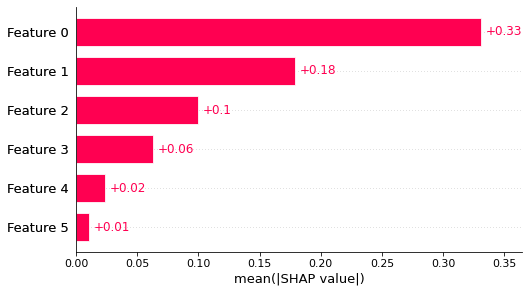

In [12]:
# explainer = shap.Explainer(xg)
# shap_values = explainer(X_np)
explainer = shap.explainers.Exact(ensemble.predict, X_np) # OK Features [0, 1, 2] are the best!
shap_values = explainer(X_np)
shap.plots.bar(shap_values)

In [5]:
# NEED TO PREPROCESS!!!
scaler = MinMaxScaler()
scaled_X_np = scaler.fit_transform(X_np)

In [20]:
# The old version of a (big) MLP.
# mlp = TorchMLP([6, 512, 512, 512, 1])
# mlp.load_state_dict(torch.load("./saved_path_inverse_burger/mlp.pth"))

# I should add batch normalization mec.
layers = [6, 50, 50, 1]
# Don't use nn.Dropout here & load the linear weights with strict=False
mlp = TorchMLP(dimensions=layers, bn=nn.LayerNorm, dropout=None)

## In case I need to do fancy loading ###
# Pretraining with [6, 50, 50, 1] (มี Dropout ปนมาด้วย)
parameters = semisup_model_state_dict
selector_parameters = OrderedDict()
# Filter only the parts that I care about renaming (to be similar to what defined in TorchMLP).
for p in parameters:
    if 'selector' in p:
        selector_parameters[p.replace("selector.nonlinear_model.", "")] = parameters[p]
selector_parameter_keys = [k for k in selector_parameters]

# Loading weights
with torch.no_grad():
    for i, p in enumerate(mlp.parameters()):
        p = selector_parameters[selector_parameter_keys[i]]

In [21]:
scaled_X_tensor = to_tensor(scaled_X_np)
y_tensor = to_tensor(y_np).reshape(-1, 1)

mlp_optim = MADGRAD(mlp.parameters(), lr=1e-3)

# mlp_optim = torch.optim.LBFGS(mlp.parameters(), 
#                               lr=5e-2, max_iter=100, max_eval=125, 
#                               history_size=120, line_search_fn='strong_wolfe')

# mlp_optim = LBFGSNew(mlp.parameters(), 
#                         lr=5e-2, max_iter=300, 
#                         max_eval=int(300*1.25), history_size=120, 
#                         line_search_fn=True, batch_mode=False)

mlp.train()
epochs = 10000; curr_loss = 1000
for i in range(epochs):
    def mlp_closure():
        if torch.is_grad_enabled():
            mlp_optim.zero_grad()
        l = F.mse_loss(mlp(scaled_X_tensor), y_tensor)
        if l.requires_grad:
            l.backward(retain_graph=False)
        return l
    
    mlp_optim.step(mlp_closure)
    l = mlp_closure()
    
    if l.item() != curr_loss:
        curr_loss = l.item()
    else: break; print("Stop training.")
    
    if (i % 1000) == 0:
        print("Epoch {}: ".format(i), curr_loss)

Epoch 0:  0.6217106580734253
Epoch 1000:  0.4935450255870819
Epoch 2000:  0.22945235669612885
Epoch 3000:  0.37543007731437683
Epoch 4000:  0.05035807937383652
Epoch 5000:  0.022527161985635757
Epoch 6000:  0.027762994170188904
Epoch 7000:  0.02186301164329052
Epoch 8000:  0.008920108899474144
Epoch 9000:  0.012585029937326908


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


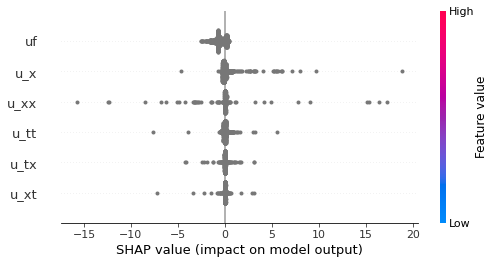

In [22]:
mlp.eval()
e = shap.DeepExplainer(mlp, scaled_X_tensor)
shap_values = e.shap_values(scaled_X_tensor)
shap.summary_plot(shap_values, features=scaled_X_tensor, feature_names=feature_names)

In [18]:
# torch.save(mlp.state_dict(), "./saved_path_inverse_burger/mlp200*3.pth")